In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

In [0]:
# Set up data folder
DATA = Path('/content/drive/My Drive/data')

## Tumor mutation burden and nivolumab response

We will investigate the relationship between pre-treatment tumor mutation burden (TMB) and the response to nivolumab.

In [0]:
clin_file = DATA / "bms038_clinical_data.csv"
clin_original = pd.read_csv(clin_file)
clin_original.head()

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
0,Pt1,Pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD
1,Pt10,Pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD
2,Pt100,Pt100_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,840,120.000000,PROGRESSION,50,7.142857,PD,SDPD
3,Pt101,Pt101_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PR,PRCR,0,1,834,119.142857,PARTIAL RESPONSE,612,87.428571,PRCRSD,PRCR
4,Pt102,Pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD


In [0]:
mut_file = DATA / "pre_therapy_nonsynonmous_mutations.csv"
mut_original = pd.read_csv(mut_file)
mut_original.head()

,Patient,Hugo Symbol,Chromosome,Start,End,Variant Classification,HGVS_c,HGVS_p,Tcov,Tac,Taf
0,Pt10,MST1L,1,17083776,17083776,missense_variant,c.2021G>T,p.Arg674Leu,232,10,0.043103
1,Pt10,MST1L,1,17083816,17083816,stop_gained,c.1981C>T,p.Arg661*,316,13,0.041139
2,Pt10,NRAS,1,115258748,115258748,missense_variant,c.34G>T,p.Gly12Cys,576,491,0.852431
3,Pt10,DCST2,1,154997000,154997000,missense_variant,c.1690C>T,p.Arg564Trp,340,37,0.108824
4,Pt10,PAPPA2,1,176525744,176525744,missense_variant,c.286A>C,p.Lys96Gln,664,53,0.079819


In [0]:
overlap_patients = set(clin_original.PatientID) & set(mut_original.Patient) 

clin = clin_original.loc[clin_original.PatientID.isin(overlap_patients), :]
mut = mut_original.loc[mut_original.Patient.isin(overlap_patients), :]

In [0]:
clin

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
1,Pt10,Pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD
2,Pt100,Pt100_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,840,120.000000,PROGRESSION,50,7.142857,PD,SDPD
3,Pt101,Pt101_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PR,PRCR,0,1,834,119.142857,PARTIAL RESPONSE,612,87.428571,PRCRSD,PRCR
4,Pt102,Pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD
5,Pt103,Pt103_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,1,484,69.142857,PROGRESSION,50,7.142857,PD,SDPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Pt90,Pt90_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,174,24.857143,PROGRESSION,44,6.285714,PD,SDPD
69,Pt92,Pt92_pre,pre,NIV3-PROG,RAS,NIV3-PROG,SD,SD,0,0,333,47.571429,STABLE DISEASE,190,27.142857,PRCRSD,SDPD
70,Pt93,Pt93_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,1,849,121.285714,PROGRESSION,51,7.285714,PD,SDPD
71,Pt94,Pt94_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,CR,PRCR,1,1,981,140.142857,COMPLETE RESPONSE,729,104.142857,PRCRSD,PRCR


In [0]:
# number of unique patients in mutation data
len(set(mut.Patient))

68

In [0]:
# tmb: tumor mutation burden
tmb = mut.groupby(["Patient"]).size()
tmb

Patient
Pt10      75
Pt100      6
Pt101     10
Pt102    393
Pt103     21
        ... 
Pt90     283
Pt92     642
Pt93       7
Pt94     405
Pt98      20
Length: 68, dtype: int64

In [0]:
tmb.min()

1

In [0]:
tmb.median()

182.5

In [0]:
tmb.max()

7360

In [0]:
tmb_df = pd.DataFrame(tmb, columns=["Num_Mut"])
tmb_df.reset_index(level=0, inplace=True)
tmb_df = tmb_df.rename(columns={"Patient":"PatientID"})
tmb_df

,PatientID,Num_Mut
0,Pt10,75
1,Pt100,6
2,Pt101,10
3,Pt102,393
4,Pt103,21
...,...,...
63,Pt90,283
64,Pt92,642
65,Pt93,7
66,Pt94,405


In [0]:
# get response data by merge it with clinical data
pd1 = pd.merge(tmb_df, clin, on="PatientID")
pd1["Log10(number of mutations)"] = np.log10(pd1.Num_Mut)
pd1

,PatientID,Num_Mut,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3,Log10(number of mutations)
0,Pt10,75,Pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD,1.875061
1,Pt100,6,Pt100_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,840,120.000000,PROGRESSION,50,7.142857,PD,SDPD,0.778151
2,Pt101,10,Pt101_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PR,PRCR,0,1,834,119.142857,PARTIAL RESPONSE,612,87.428571,PRCRSD,PRCR,1.000000
3,Pt102,393,Pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD,2.594393
4,Pt103,21,Pt103_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,1,484,69.142857,PROGRESSION,50,7.142857,PD,SDPD,1.322219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Pt90,283,Pt90_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,174,24.857143,PROGRESSION,44,6.285714,PD,SDPD,2.451786
64,Pt92,642,Pt92_pre,pre,NIV3-PROG,RAS,NIV3-PROG,SD,SD,0,0,333,47.571429,STABLE DISEASE,190,27.142857,PRCRSD,SDPD,2.807535
65,Pt93,7,Pt93_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,1,849,121.285714,PROGRESSION,51,7.285714,PD,SDPD,0.845098
66,Pt94,405,Pt94_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,CR,PRCR,1,1,981,140.142857,COMPLETE RESPONSE,729,104.142857,PRCRSD,PRCR,2.607455


Text(0, 0.5, 'Log10(number of mutations)')

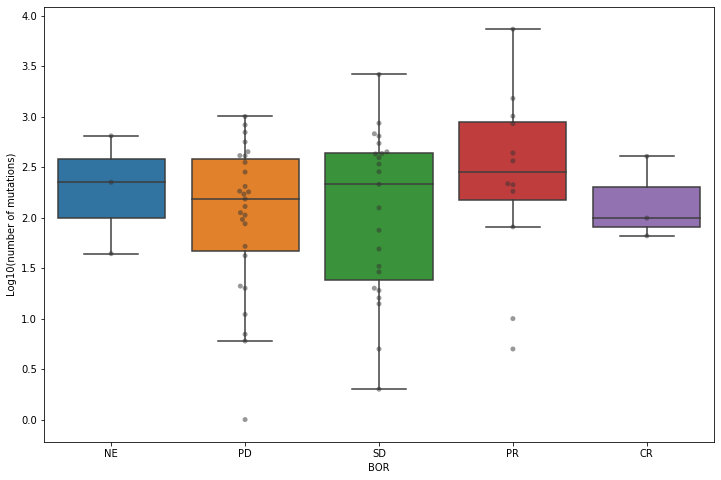

In [0]:
# a boxplot with x-axis indicating different response groups (BOR)
# and y-axis as the Log10 transformed number of mutations
fig, axarr = plt.subplots(1, 1)
fig.set_size_inches(12, 8)
sns.boxplot(x="BOR", y="Log10(number of mutations)", data=pd1, 
            order=["NE", "PD", "SD", "PR", "CR"], fliersize=0, ax=axarr)
sns.swarmplot(x="BOR", y="Log10(number of mutations)", data=pd1, 
              order=["NE", "PD", "SD", "PR", "CR"], color=".2", alpha=0.5, ax=axarr)
axarr.set_ylabel("Log10(number of mutations)")

Compare the TMBs between patients with partial or complete response (`PR`, `CR`) and patients with stable disease or progression (`SD`, `PD`).

In [0]:
mannwhitneyu(pd1.loc[pd1.BOR.isin(["PD", "SD"]), "Num_Mut"],
             pd1.loc[pd1.BOR.isin(["PR", "CR"]), "Num_Mut"])

MannwhitneyuResult(statistic=298.5, pvalue=0.11833637016018267)

## Tumor mutation burden and overall survival in Ipilimumab-Naive patients

Reference: [Riaz _et al._](https://doi.org/10.1016/j.cell.2017.09.028)

In [0]:
# Create a subset of clinical data and mutation data containing only patients
# who have never received ipilimumab (Cohort == NIV3-NAIVE)
clin_naive = clin.loc[clin.Cohort.isin(['NIV3-NAIVE']), :]
clin_naive.shape

(33, 17)

In [0]:
mut_naive = mut.loc[mut.Patient.isin(clin_naive.PatientID), :]
len(set(mut_naive.Patient))

33

In [0]:
# Fit a Cox model in the ipilimumab-naive patients using log10-transformed
# tumor mutation burden as the single variable, and overall survival as
# the target variable.

# Calculate tumor mutation burden first
tmb_naive = mut_naive.groupby(["Patient"]).size()
len(tmb_naive)

33

In [0]:
tmb_naive_df = pd.DataFrame(tmb_naive, columns=["Num_Mut"])
tmb_naive_df.reset_index(level=0, inplace=True)
tmb_naive_df = tmb_naive_df.rename(columns={"Patient":"PatientID"})
tmb_naive_df.head()

,PatientID,Num_Mut
0,Pt10,75
1,Pt102,393
2,Pt11,106
3,Pt13,171
4,Pt18,217


In [0]:
pfs = pd.merge(tmb_naive_df, clin_naive, on="PatientID")
pfs["log10_transformed_TMB"] = np.log10(pfs.Num_Mut)
pfs["OS_event"] = 1-pfs['OS_SOR']
pfs.head()

,PatientID,Num_Mut,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3,log10_transformed_TMB,OS_event
0,Pt10,75,Pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD,1.875061,1
1,Pt102,393,Pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD,2.594393,0
2,Pt11,106,Pt11_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PD,PD,0,0,837,119.571429,PROGRESSION,59,8.428571,PD,SDPD,2.025306,1
3,Pt13,171,Pt13_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PD,PD,0,0,280,40.000000,PROGRESSION,62,8.857143,PD,SDPD,2.232996,1
4,Pt18,217,Pt18_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PR,PRCR,0,1,1073,153.285714,NaN,519,74.142857,PRCRSD,PRCR,2.336460,0


In [0]:
pfs.shape

(33, 20)

In [0]:
mat = pfs[["PatientID", "OS", "OS_event", "log10_transformed_TMB"]].copy()
mat.set_index("PatientID", inplace=True)
mat.head()

,OS,OS_event,log10_transformed_TMB
PatientID,,,
Pt10,256,1,1.875061
Pt102,636,0,2.594393
Pt11,837,1,2.025306
Pt13,280,1,2.232996
Pt18,1073,0,2.336460


In [0]:
mat.shape

(33, 3)

In [0]:
cph = CoxPHFitter()
cph.fit(mat, duration_col='OS', event_col='OS_event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
log10_transformed_TMB,-0.62363,0.535995,0.381198,-1.370765,0.123505,0.253913,1.131456,-1.635971,0.101846,3.295545


Finally, use a Kaplan-Meier curve to compare two groups of patients: patients with high mutation burden (number of mutations >= 100 as defined in the Riaz paper), and patients with low mutation burden (number of mutations < 100).

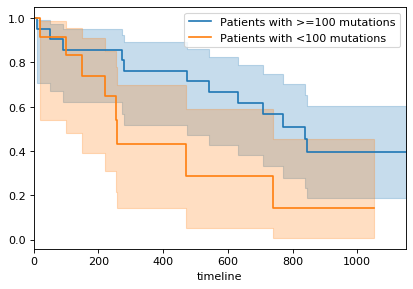

In [0]:
high_idx = pfs.Num_Mut>=100

fig, ax = plt.subplots(dpi=80)
kmf = KaplanMeierFitter()
kmf.fit(pfs.OS[high_idx], pfs.OS_event[high_idx], label='Patients with >=100 mutations')
kmf.plot(ax=ax)
kmf.fit(pfs.OS[~high_idx], pfs.OS_event[~high_idx], label='Patients with <100 mutations')
kmf.plot(ax=ax)